In [6]:
import matplotlib
%matplotlib inline
import numpy as np, matplotlib.pyplot as plt
from matplotlib.cm import rainbow

In [7]:
N_z, N_bins = 60, 100
P_Mz = np.random.rand( N_z, N_bins )

In [11]:
P = np.cumsum( P_Mz, axis=0 )

This is not needed, since all the info is already incoded in results of Rodrigues et al.

In [2]:
def Schechter( M, M_star=1, phi1=1, alpha1=1, phi2=1, alpha2=1):
    return ( phi1 * ( M / M_star )**alpha1 + phi2 * ( M / M_star )**alpha2 ) * np.exp( -M/M_star ) / M_star

In [3]:
## Best fit parameters from Davidzon et al. 2017, Tab. 1, redshifts are extended to z=0 and z=6
parameters = np.genfromtxt( 'COSMOS2015_Schechter_fit.txt', names=True)
parameters['M_star'] = 10.**parameters['M_star']

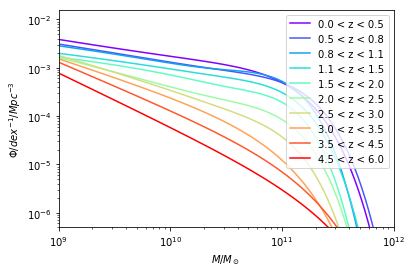

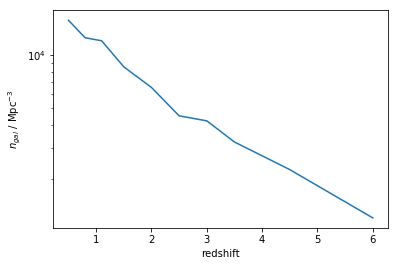

In [17]:
Ms = 10.**np.linspace(9,12,101)
dMs = np.diff(Ms)
n_gal = []
colors = rainbow( np.linspace( 0, 1, len(parameters) ) )
for p, c in zip( parameters, colors ):
    phi = Schechter( Ms, M_star=p['M_star']*1.067, phi1=p['phi1'], alpha1=p['alpha1'], phi2=p['phi2'], alpha2=p['alpha2']) 
    ### correct unit prefactors !!!
    n_gal.append( np.sum( phi[:-1]*dMs ) )
    plt.loglog( Ms[:-1]+dMs/2, phi[:-1]*dMs/110.2, label='%.1f < z < %.1f' % ( p['z0'], p['z1'] ), color=c )
plt.legend()
plt.xlabel('$M/M_\odot$')
plt.ylabel('$\Phi/dex^{-1}/Mpc^{-3}$')
plt.ylim(10.**-6.3, 10.**-1.8)
plt.xlim(1e9, 1e12)
plt.show()

plt.plot( parameters['z1'], n_gal )
plt.ylabel('$n_{gal}$ / Mpc$^{-3}$')
plt.xlabel('redshift')
plt.yscale('log')
plt.show()

In [13]:
len(parameters)


10

In [17]:
import yt
co = yt.utilities.cosmology.Cosmology()
radial_distance = co.comoving_radial_distance